In [21]:
# imports
import pandas as pd

In [22]:
# file paths
json_path = 'datasets/dataset1.json'
csv_path = 'datasets/dataset2.csv'
pdf_path = 'datasets/dataset3.pdf'
pptx_path = 'datasets/dataset4.pptx'

Import JSON

In [23]:
json_df = pd.read_json(json_path)
json_df.head()

,companies
0,"{'id': 1, 'name': 'FitPro', 'industry': 'Sport..."
1,"{'id': 2, 'name': 'RecreaLife', 'industry': 'S..."


Process JSON

In [24]:
companies_df = pd.DataFrame(columns=['id', 'name', 'industry', 'revenue', 'location'])
companies_revenue_df = pd.DataFrame(columns=['company_id', 'year', 'quarter', 'revenue'])
companies_profit_margin_df = pd.DataFrame(columns=['company_id', 'year', 'quarter', 'profit_margin'])
employees_df = pd.DataFrame(columns=['id', 'name', 'company_id', 'role', 'salary', 'hired_date'])

In [25]:
for index, row in json_df.iterrows():
    # process company json data
    company_data = row['companies']
    companies_df = pd.concat([companies_df, pd.DataFrame([{
        'id': company_data.get('id'),
        'name': company_data.get('name'),
        'industry': company_data.get('industry'),
        'revenue': company_data.get('revenue'),
        'location': company_data.get('location')
    }])], ignore_index=True)
    
    performance_data = company_data.get('performance', {})

    for quarter in performance_data.keys():
        year, qtr = quarter.split('_')
        companies_revenue_df = pd.concat([companies_revenue_df, pd.DataFrame([{
            'company_id': company_data.get('id'),
            'year': year,
            'quarter': qtr,
            'revenue': performance_data.get(quarter, {}).get('revenue')
        }])], ignore_index=True)
        
        companies_profit_margin_df = pd.concat([companies_profit_margin_df, pd.DataFrame([{
            'company_id': company_data.get('id'),
            'year': year,
            'quarter': qtr,
            'profit_margin': performance_data.get(quarter, {}).get('profit_margin')
        }])], ignore_index=True)
    
    for employee in company_data.get('employees', []):
        employees_df = pd.concat([employees_df, pd.DataFrame([{
            'id': employee.get('id'),
            'name': employee.get('name'),
            'company_id': company_data.get('id'),
            'role': employee.get('role'),
            'salary': employee.get('salary'),
            'hired_date': employee.get('hired_date')
        }])], ignore_index=True)

/var/folders/bb/3x7ks28j6mldq2nsqsf09zfh0000gn/T/ipykernel_11647/2190827941.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  companies_profit_margin_df = pd.concat([companies_profit_margin_df, pd.DataFrame([{


Import CSV

In [26]:
csv_df = pd.read_csv(csv_path)

In [27]:
csv_df.head()

,Date,Membership_ID,Membership_Type,Activity,Revenue,Duration (Minutes),Location
0,2024-01-21,M001,Basic,Gym,113.82,60,Downtown
1,2024-01-05,M002,VIP,Pool,104.74,30,Eastside
2,2024-01-14,M003,Basic,Gym,23.12,60,Eastside
3,2024-01-20,M004,Basic,Personal Training,110.24,120,Downtown
4,2024-01-15,M005,VIP,Dance Class,123.32,30,Downtown


In [44]:
# save as json
csv_df.to_json('datasets/dataset2.json', orient='records')

Import PDF

In [28]:
import pdfplumber
pdf = pdfplumber.open(pdf_path)
page = pdf.pages[0]
page.extract_table()

[['Year',
  'Quarter',
  'Revenue (in $)',
  'Memberships Sold',
  'Avg Duration (Minutes)'],
 ['2022', 'Q1', '2,100,000', '300', '85'],
 ['2022', 'Q2', '2,300,000', '320', '87'],
 ['2022', 'Q3', '2,500,000', '340', '89'],
 ['2022', 'Q4', '2,700,000', '360', '88'],
 ['2023', 'Q1', '2,300,000', '320', '90'],
 ['2023', 'Q2', '2,500,000', '400', '95'],
 ['2023', 'Q3', '2,700,000', '350', '100'],
 ['2023', 'Q4', '2,900,000', '450', '92'],
 ['2024', 'Q1', '3,100,000', '420', '88'],
 ['2024', 'Q2', '3,300,000', '500', '90']]

In [29]:
table = page.extract_table()
pdf_table_df = pd.DataFrame(table[1:], columns=table[0])
pdf_table_df.head()

,Year,Quarter,Revenue (in $),Memberships Sold,Avg Duration (Minutes)
0,2022,Q1,"2,100,000",300,85
1,2022,Q2,"2,300,000",320,87
2,2022,Q3,"2,500,000",340,89
3,2022,Q4,"2,700,000",360,88
4,2023,Q1,"2,300,000",320,90


In [45]:
pdf_table_df.to_json('datasets/dataset3.json', orient='records')

Import pptx

In [30]:
from pptx import Presentation
pptx = Presentation(pptx_path)

In [31]:
text_data = ""
for slide in pptx.slides:
    for shape in slide.shapes:
        if shape.has_text_frame:
            text = shape.text
            text_data += text + "\n"
        if shape.has_table:
            table = shape.table
            for row in table.rows:
                row_data = [cell.text for cell in row.cells]
                text_data += " | ".join(row_data) + "\n"

In [32]:
import json
import re

# Function to parse key highlights
def parse_key_highlights(data):
    highlights = {}
    revenue_match = re.search(r"Total Revenue:\s*\$([\d,]+)", data)
    memberships_match = re.search(r"Total Memberships Sold:\s*([\d,]+)", data)
    location_match = re.search(r"Top Location:\s*([\w\s]+)", data)

    if revenue_match:
        highlights["TotalRevenue"] = int(revenue_match.group(1).replace(",", ""))
    if memberships_match:
        highlights["TotalMembershipsSold"] = int(memberships_match.group(1).replace(",", ""))
    if location_match:
        highlights["TopLocation"] = location_match.group(1).strip()

    return highlights

# Function to parse tables based on "|" delimiter
def parse_table(data, header_row_indicator="Quarterly Metrics"):
    rows = []
    table_started = False
    headers = []

    for line in data.split("\n"):
        if header_row_indicator in line:
            table_started = True
            continue  # Skip the header row indicator
        if table_started and "|" in line:
            row_data = [entry.strip() for entry in line.split("|")]
            if not headers:  # First row is treated as headers
                headers = row_data
            else:
                row = {headers[i]: int(entry.replace(",", "")) if entry.replace(",", "").isdigit() else entry for i, entry in enumerate(row_data)}
                rows.append(row)

    return rows

# Function to parse revenue breakdown
def parse_revenue_breakdown(data):
    breakdown = {}
    matches = re.findall(r"([\w\s]+):\s*(\d+)%", data)
    for match in matches:
        activity, percentage = match
        breakdown[activity.strip()] = int(percentage)
    return breakdown

# Main function to parse combined text data
def parse_text_to_json(text_data):
    result = {}

    if "Key Highlights" in text_data:
        result["KeyHighlights"] = parse_key_highlights(text_data)

    if "Quarterly Metrics" in text_data:
        result["QuarterlyMetrics"] = parse_table(text_data)

    if "Revenue Breakdown by Activity" in text_data:
        result["RevenueBreakdownByActivity"] = parse_revenue_breakdown(text_data)

    return result

In [46]:
# Parse the continuous text data
parsed_data = parse_text_to_json(text_data)
print(json.dumps(parsed_data, indent=4))

# Save the parsed data as JSON
with open('datasets/dataset4.json', 'w') as f:
    json.dump(parsed_data, f, indent=4)

{
    "KeyHighlights": {
        "TotalRevenue": 10400000,
        "TotalMembershipsSold": 1520,
        "TopLocation": "Downtown\nQuarterly Metrics\nQuarter"
    },
    "QuarterlyMetrics": [
        {
            "Quarter": "Q1",
            "Revenue (in $)": 2300000,
            "Memberships Sold": 320,
            "Avg Duration (Minutes)": 90
        },
        {
            "Quarter": "Q2",
            "Revenue (in $)": 2500000,
            "Memberships Sold": 400,
            "Avg Duration (Minutes)": 95
        },
        {
            "Quarter": "Q3",
            "Revenue (in $)": 2700000,
            "Memberships Sold": 350,
            "Avg Duration (Minutes)": 100
        },
        {
            "Quarter": "Q4",
            "Revenue (in $)": 2900000,
            "Memberships Sold": 450,
            "Avg Duration (Minutes)": 92
        }
    ],
    "RevenueBreakdownByActivity": {
        "Gym": 40,
        "Pool": 25,
        "Tennis Court": 15,
        "Personal Training": 2

Data Visualisation Exploration

PPTX

In [34]:
total_revenue = parsed_data.get("KeyHighlights", {}).get("TotalRevenue")
total_memberships_sold = parsed_data.get("KeyHighlights", {}).get("TotalMembershipsSold")

class quarter_metric:
    def __init__(self, quarter_data):
        self.quarter = quarter_data.get("Quarter")
        self.revenue = quarter_data.get("Revenue (in $)")
        self.memberships_sold = quarter_data.get("Memberships Sold")
        self.avg_duration = quarter_data.get("Avg Duration (Minutes)")
    
    def revenue_per_member(self):
        return self.revenue / self.memberships_sold if self.memberships_sold else 0
    
    def revenue_per_minute(self):
        return self.revenue / self.total_minutes() if self.total_minutes() else 0

    def total_minutes(self):
        return self.avg_duration * self.memberships_sold if self.memberships_sold else 0
    


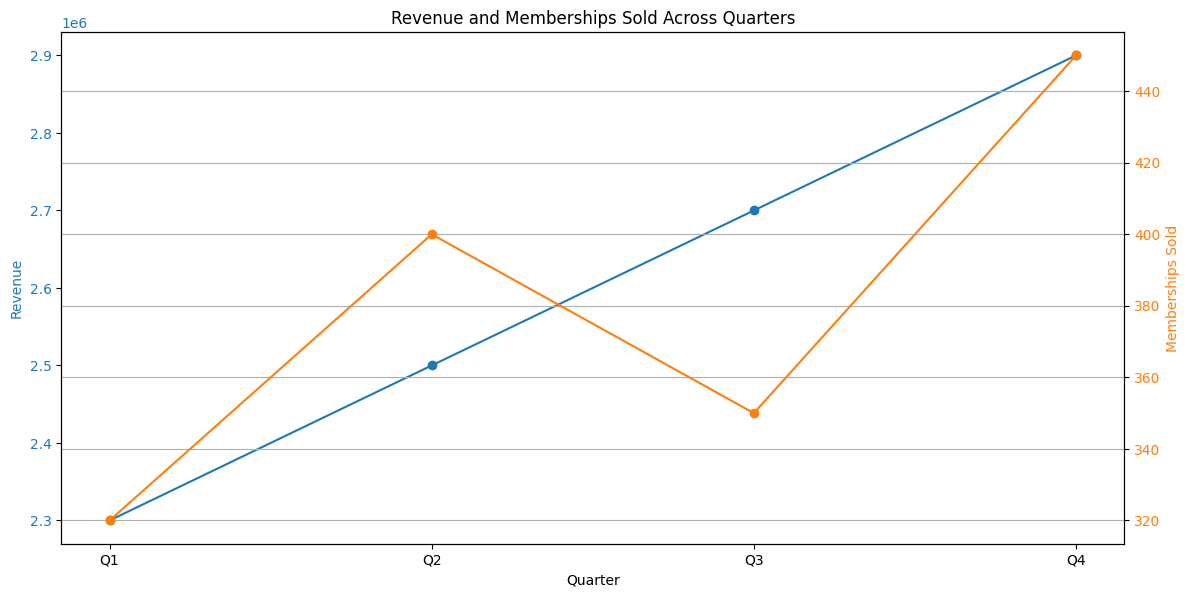

In [35]:
import matplotlib.pyplot as plt

# Extract quarterly metrics
quarterly_metrics = [quarter_metric(metric) for metric in parsed_data.get("QuarterlyMetrics", [])]
quarters = [metric.quarter for metric in quarterly_metrics]
revenues = [metric.revenue for metric in quarterly_metrics]
memberships_sold = [metric.memberships_sold for metric in quarterly_metrics]

# Plotting the data
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Quarter')
ax1.set_ylabel('Revenue', color='tab:blue')
ax1.plot(quarters, revenues, label='Revenue', marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Memberships Sold', color='tab:orange')
ax2.plot(quarters, memberships_sold, label='Memberships Sold', marker='o', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Revenue and Memberships Sold Across Quarters')
plt.grid(True)
plt.show()

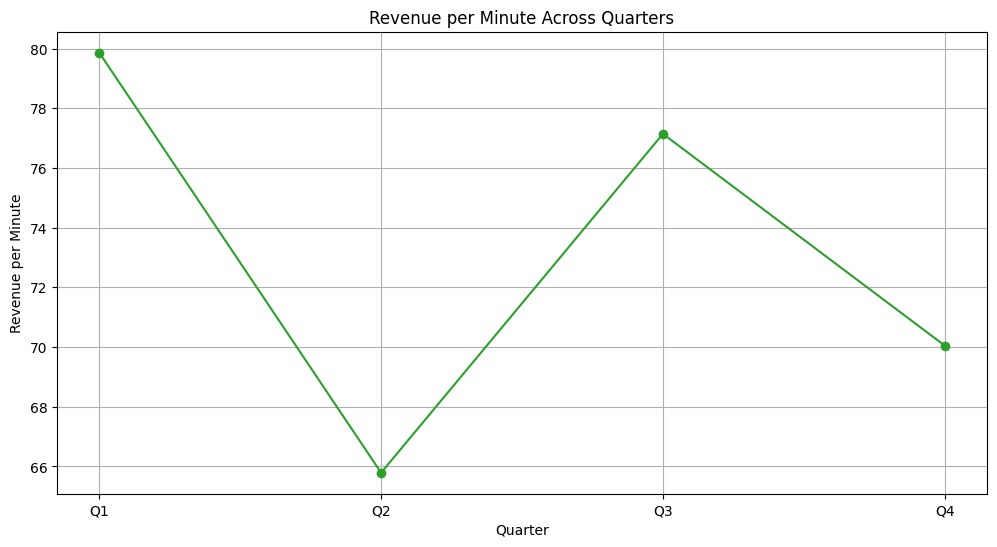

In [36]:
# Calculate revenue per minute for each quarter
revenue_per_minute = [metric.revenue_per_minute() for metric in quarterly_metrics]

plt.figure(figsize=(12, 6))
plt.plot(quarters, revenue_per_minute, marker='o', linestyle='-', color='tab:green')
plt.xlabel('Quarter')
plt.ylabel('Revenue per Minute')
plt.title('Revenue per Minute Across Quarters')
plt.grid(True)
plt.show()

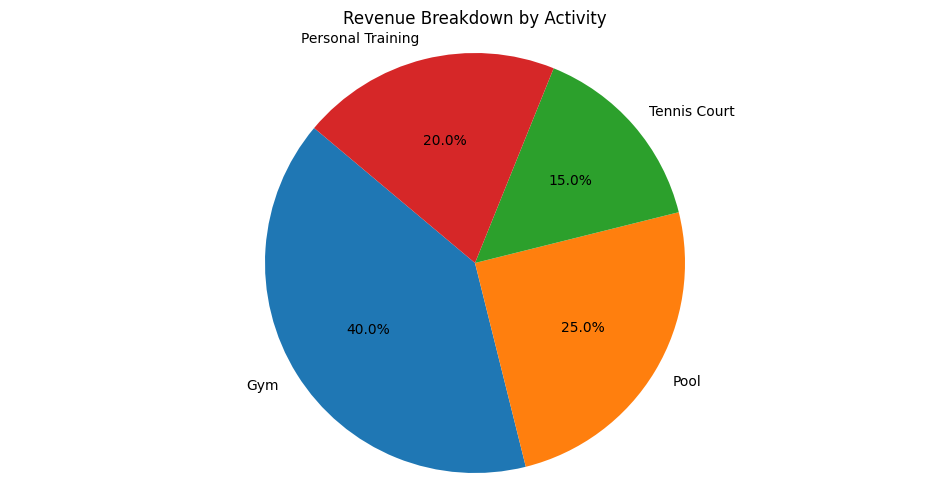

In [37]:
# revenue breakdown by activity
revenue_breakdown = parsed_data.get("RevenueBreakdownByActivity", {})
activities = list(revenue_breakdown.keys())
percentages = list(revenue_breakdown.values())

plt.figure(figsize=(12, 6))
plt.pie(percentages, labels=activities, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Revenue Breakdown by Activity')
plt.show()

From PDF

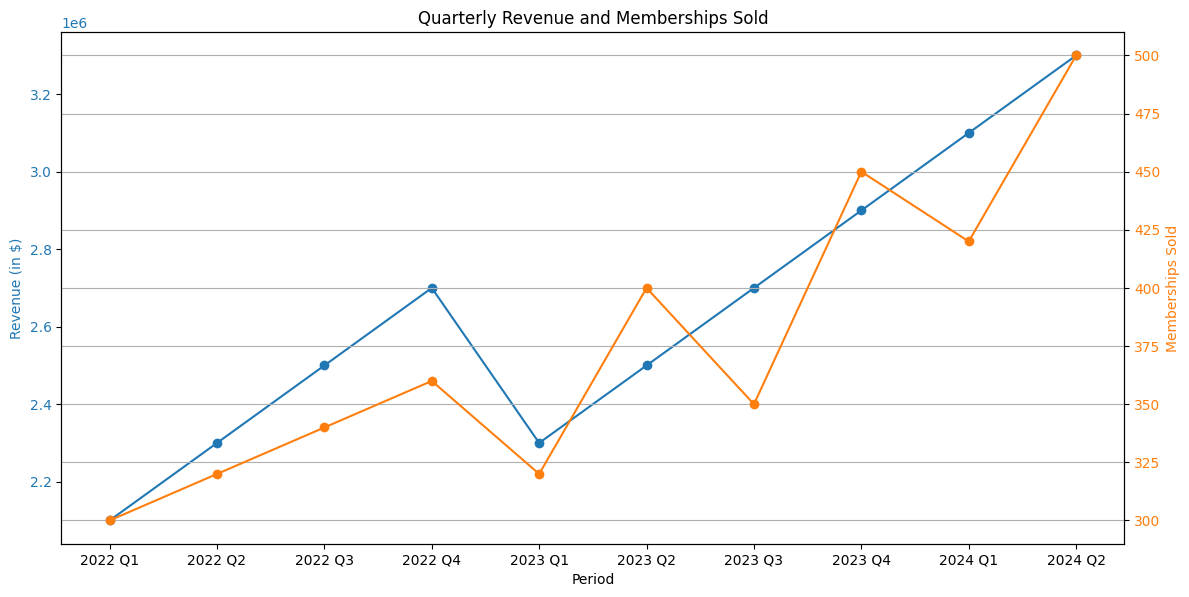

In [42]:
# Combine 'Year' and 'Quarter' columns to create a new 'Period' column
pdf_table_df['Period'] = pdf_table_df['Year'] + ' ' + pdf_table_df['Quarter']

# Convert 'Revenue (in $)' and 'Memberships Sold' columns to numeric
pdf_table_df['Revenue (in $)'] = pdf_table_df['Revenue (in $)'].astype(float)
pdf_table_df['Memberships Sold'] = pdf_table_df['Memberships Sold'].astype(int)

# Plot pdf table data with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Period')
ax1.set_ylabel('Revenue (in $)', color='tab:blue')
ax1.plot(pdf_table_df['Period'], pdf_table_df['Revenue (in $)'], label='Revenue (in $)', marker='o', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Memberships Sold', color='tab:orange')
ax2.plot(pdf_table_df['Period'], pdf_table_df['Memberships Sold'], label='Memberships Sold', marker='o', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('Quarterly Revenue and Memberships Sold')
plt.grid(True)
plt.show()